In [1]:
# Let me start by giving a little PERSPECTIVE into how I have written this notebook. I beleive that the most efficient EDA is when it happens from a particular point of view.
# I have taken the point of view of an investor, how he/she looks forward to use data science to earn more money. Hence, I have posed and answered questions in the similar way.

In [2]:
# Your Github repository must have the following contents:

# A README.md file that communicates 
#   the libraries used,
#   the motivation for the project,
#   the files in the repository with a small description of each,
#   a summary of the results of the analysis,
#   and necessary acknowledgments.
# Your code in a Jupyter notebook, with appropriate comments, analysis, and documentation.

# question 1: what are the factors that justifies high price of AirBnBs. what factors makes them PREMIUM!
# answer 1:
#   we do not have many exmaples in our dataset to support this result but using general logic, we can say that larger square footage does costs more
#   and same goes for amenities as well. the more you offer to your guests, the more they will be willing to pay for, and this time we do have a lot of examples in support
#   okay the next point goes in-sync with our amenities question - we saw that kid/family friendly envionment in AirBnBs in top price band, relative to that
#   we here see accommodating more guests gives us more bucks. which is again fair going by general conscience
#   one last thing, looking into price trends in neighbourhoods of Boston, buy that property in Back Bay, the highend shops and all the fashion boutiques will benifit you

# question 2: difference in amenities offered by top and bottom 10 percentile (by Price) AirBnBs?
# answer 2: 
#   main emenities offered by AirBnBs in top price band are - ac, tv, internet, and kid/family freindly environment
#   though carbon monoxide detector is nice to have to have an alert on harmful air components around us, it is suprising it does not make it to the list from top band
#   AirBnBs but from the lower band. anyway, it is what it is

# question 3: what is the best time to properties up as AirBnBs
# answer 3:
#   we saw that most of the the trafic that AirBnBs experience is near the fall except for say an exception in april 2017

In [3]:
import pandas as pd, seaborn as sns, numpy as np, datetime
from collections import Counter

In [4]:
def data_preprocessing_listing_df(df):
    '''
    input: pandas dataframe
    output: pandas dataframe
    functionality: 
        1) the function removes junk columns from the dataframe
        2) the function tranforms data in 'price', 'amenities', and 'house_rules' columns
        3) the function generates synthetic columns from 'amenities' and 'house_rules' columns
    '''

    # removing junk columns (for example, columns with url) from the dataframe
    columns_to_keep = ['id', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_is_superhost', 'host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']
    df = df[columns_to_keep]

    # 'price' column does not contain any nulls but it does have 'object' datatype along with '$' and ',' present in row entries
    # hence removing '$' and ',' sign from 'price' column and finally converting datatype from 'object' to 'float'
    df['price'] = df['price'].apply(lambda x: x.replace('$', '').replace(',', '').strip()).astype('float')

    # 'amenties' column in the dataframe is in text format and needs NLP to extract information from this raw format
    # since we plan to use this column further down the road in our analysis and will not be using NLP, it is good to tranform it into a form that is useful for us
    df['amenities'] = df['amenities'].apply(lambda x: [i.strip() for i in x.replace('"', '').replace('{', '').replace('}', '').split(',')])
    df['amenity_count'] = df['amenities'].apply(lambda x: len(x))

    # 'house_rules' column in the dataframe is also in text format and needs NLP to extract information from this raw format
    # since we plan to use this column further down the road in our analysis and will not be using NLP, it is good to tranform it into a form that is useful for us
    df['house_rules'] = df['house_rules'].fillna('').apply(lambda x: x.split('.'))
    df['house_rules_count'] = df['house_rules'].fillna('').apply(lambda x: len(x))

    return(df)

In [5]:
def data_preprocessing_calendar_df(df):
    '''
    input: pandas dataframe
    output: pandas dataframe
    functionality: 
        1) the function tranforms data in 'price' and 'date' columns
        3) the function generates synthetic column from 'date' column
    '''

    # filling up nulls in 'price' column with '0' as these nulls corresponds to days when the listings were not available
    # 'price' column is of 'object' datatype and also contain '$' and ',' in row entries. removing '$' and ',' and changing datatype to 'float'
    df['price'] = df['price'].fillna('0').apply(lambda x: x.replace('$', '').replace(',', '').strip()).astype('float')

    # converting datatype of 'date' column from 'object' to 'datetime64'
    df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))

    # creating synthetic column in the dataframe to reprent year-month of the corresponding date
    df['year_month'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str')
    df['year_month'] = df['year_month'].apply(lambda x: x if len(x.split('-')[-1]) == 2 else x[:5] + '0' + x[5:])

    return(df)

In [6]:
def plot_bargraph(data_dict, x_label_string, y_label_string, graph_title_string):
    '''
    input:
        1) amenity_dict: python dictionary fethced from get_top_amenities_dict function
        2) x_label_string: python string indicating x-axis label
        3) y_label_string: python string indicating y-axis label
        4) graph_title_string: python string indicating barplot title

    output: None
    functionality: generates a barplot of key-value pairs of the provided dictionary
    '''

    sns.set(rc={'figure.figsize':(18,7)}, font_scale = 1.75)
    sns.set_context('paper')
    sns.set_style('white')
    sns.despine()

    ax = sns.barplot(y = list(data_dict.keys()), x = list(data_dict.values()), color = 'skyblue')
    ax.set_xlabel(x_label_string, size = 14)
    ax.set_ylabel(y_label_string, size = 14)
    ax.set_title(graph_title_string, size = 18);
    fig = ax.get_figure()
    fig.savefig(f'{graph_title_string}.png', dpi=400)
    return(None)

In [7]:
def plot_histogram(data_series, x_label_string, graph_title_string):
    '''
    input:
        1) data_series: pandas series with a continuous variable (int or float)
        2) x_label_string: python string indicating x-axis label
        3) graph_title_string: python string indicating barplot title

    output: None
    functionality: generates a histogram of the provided pandas series
    '''

    sns.set(rc={'figure.figsize':(18,7)}, font_scale = 1.75)
    sns.set_context('paper')
    sns.set_style('white')
    sns.despine()
    
    ax = sns.histplot(x = data_series, color = 'skyblue')
    ax.set_xlabel(x_label_string, size = 14)
    ax.set_title(graph_title_string, size = 18);
    fig = ax.get_figure()
    fig.savefig(f'{graph_title_string}.png', dpi=400)

    return(None)

In [8]:
def plot_lineplot(df, x_axis_col, y_axis_col, x_label_string, y_label_string, graph_title_string):
    '''
    input:
        1) df: pandas dataframe with columns for x and y axis
        2) x_axis_col: python string indicating column name of variable on x-axis
        3) y_axis_col: python string indicating column name of variable on y-axis
        4) x_label_string: python string indicating x-axis label
        5) y_label_string: python string indicating y-axis label
        6) graph_title_string: python string indicating barplot title

    output: None
    functionality: generates a barplot of key-value pairs of the provided dictionary
    '''

    sns.set(rc={'figure.figsize':(18,7)}, font_scale = 1.75)
    sns.set_context('paper')
    sns.set_style('white')
    sns.despine()

    ax = sns.lineplot(x = x_axis_col, y = y_axis_col, data = df, color = 'skyblue')

    ax.set_xlabel(x_label_string, size = 14)
    ax.set_ylabel(y_label_string, size = 14)
    ax.set_title(graph_title_string, size = 18);
    fig = ax.get_figure()
    fig.savefig(f'{graph_title_string}.png', dpi=400)

    return(None)

In [9]:
def plot_boxplot(df, x_axis_col, y_axis_col, x_label_string, y_label_string, graph_title_string):
    '''
    input:
        1) df: pandas dataframe with columns for x and y axis
        2) x_axis_col: python string indicating column name of variable on x-axis
        3) y_axis_col: python string indicating column name of variable on y-axis
        4) x_label_string: python string indicating x-axis label
        5) y_label_string: python string indicating y-axis label
        6) graph_title_string: python string indicating barplot title

    output: None
    functionality: generates a barplot of key-value pairs of the provided dictionary
    '''

    sns.set(rc={'figure.figsize':(18,7)}, font_scale = 1.75)
    sns.set_context('paper')
    sns.set_style('white')
    sns.despine()

    ax = sns.boxplot(x = x_axis_col, y = y_axis_col, data = df, color = 'skyblue')

    ax.set_xlabel(x_label_string, size = 14)
    ax.set_ylabel(y_label_string, size = 14)
    ax.set_title(graph_title_string, size = 18);
    fig = ax.get_figure()
    fig.savefig(f'{graph_title_string}.png', dpi=400)
    return(None)

In [10]:
calendar_df = pd.read_csv('calendar.csv')
listings_df = pd.read_csv('listings.csv')

listings_df = data_preprocessing_listing_df(listings_df)
calendar_df = data_preprocessing_calendar_df(calendar_df)

/Users/vaibhavgupta/opt/anaconda3/envs/env_data_scientist_nanodegree/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/vaibhavgupta/opt/anaconda3/envs/env_data_scientist_nanodegree/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/vaibhavgupta/opt/anaconda3/envs/env_data_scientist_nanodegree/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on

# Question 1

In [11]:
# that is enough data preprocessing for now!!! Let's move onto answering our first question
# let's see what are the factors that justifies high price of AirBnBs. or let's say what makes them PREMIUM!

# let's start with separating out top 5 percentile AirBnBs from rest of the crowd
price_95_percentile = listings_df['price'].quantile(q = 0.95)
top_5_percentile_dataframe = listings_df[listings_df['price'] >= price_95_percentile].reset_index(drop = True)
bottom_95_percentile_dataframe = listings_df[listings_df['price'] < price_95_percentile].reset_index(drop = True)

In [12]:
# let's check how many AirBnBs we have in each dataframes
len_top_5, len_bottom_95 = len(top_5_percentile_dataframe), len(bottom_95_percentile_dataframe)
print(f'We have {len_top_5} AirBnBs in top 5 percentile range and {len_bottom_95} AirBnBs in bottom 95 percentile range.')

We have 191 AirBnBs in top 5 percentile range and 3394 AirBnBs in bottom 95 percentile range.


In [13]:
# let's see if there is any difference in square footage between these 2 groups
print(f"Top 5 percentile AirBnBs have an average of {round(top_5_percentile_dataframe['square_feet'].mean(), 2)} sq. ft. of area.")
print(f"Bottom 95 percentile AirBnBs have an average of {round(bottom_95_percentile_dataframe['square_feet'].mean(), 2)} sq. ft of area.")

print()
# we do see a significant difference in square footage but let's see if we have enough samples available to actually put this into use
print(f"We have {round(100 * top_5_percentile_dataframe['square_feet'].isnull().sum()/len_top_5, 2)}% of null values.")
print(f"We have {round(100 * bottom_95_percentile_dataframe['square_feet'].isnull().sum()/len_bottom_95, 2)}% of null values.")

Top 5 percentile AirBnBs have an average of 1430.4 sq. ft. of area.
Bottom 95 percentile AirBnBs have an average of 802.39 sq. ft of area.

We have 97.38% of null values.
We have 98.5% of null values.


In [14]:
# though we do not have enough samples, we do have almost equal percentage of missing values. we can conclude this result can generalize well over the entire population
# let's see what else we got
# see if we have any difference between average number of amenities offered by these two groups
print(f"AirBnBs falling in Top 5 percentile group offers {round(top_5_percentile_dataframe['amenity_count'].mean(), 2)} amenities on an avaerage.")
print(f"AirBnBs falling in Bottom 95 percentile group offers {round(bottom_95_percentile_dataframe['amenity_count'].mean(), 2)} amenities on an avaerage.")

print()
# we do see a difference in average amenities offered but let's see if we have enough samples available to actually put this into use
print(f"We have {round(100 * np.sum(top_5_percentile_dataframe['amenity_count'] == 0)/len_top_5, 2)}% of null values.")
print(f"We have {round(100 * np.sum(bottom_95_percentile_dataframe['amenity_count'] == 0)/len_bottom_95, 2)}% of null values.")

# yep, no nulls, we can use this result! let's see what else we can get

AirBnBs falling in Top 5 percentile group offers 17.89 amenities on an avaerage.
AirBnBs falling in Bottom 95 percentile group offers 15.75 amenities on an avaerage.

We have 0.0% of null values.
We have 0.0% of null values.


In [15]:
# let's see if higher priced AirBnBs accommodates more guests or not

print(f"AirBnBs falling in Top 5 percentile group accommodates {round(top_5_percentile_dataframe['accommodates'].mean(), 2)} guests on an avaerage.")
print(f"AirBnBs falling in Bottom 95 percentile group accommodates {round(bottom_95_percentile_dataframe['accommodates'].mean(), 2)} guests on an avaerage.")

print()
# we do see a difference in average accommodates offered but let's see if we have enough samples available to actually put this into use
print(f"We have {round(100 * top_5_percentile_dataframe['accommodates'].isnull().sum()/len_top_5, 2)}% of null values.")
print(f"We have {round(100 * bottom_95_percentile_dataframe['accommodates'].isnull().sum()/len_bottom_95, 2)}% of null values.")

AirBnBs falling in Top 5 percentile group accommodates 5.48 guests on an avaerage.
AirBnBs falling in Bottom 95 percentile group accommodates 2.9 guests on an avaerage.

We have 0.0% of null values.
We have 0.0% of null values.


In [16]:
def get_neighbourhood_cleansed_breakup(neighbourhood_cleaned_series):
    return(round(100 * neighbourhood_cleaned_series.value_counts()/len(neighbourhood_cleaned_series), 2).to_dict())

# good! we again see a significant difference and have more reasons to why guests pays more for some of the listings
# let's see if 'neighbourhood_cleansed' column provides any insight in this comparison
neighbourhood_dict_top_5_percentile = get_neighbourhood_cleansed_breakup(top_5_percentile_dataframe['neighbourhood_cleansed'])
neighbourhood_dict_bottom_95_percentile = get_neighbourhood_cleansed_breakup(bottom_95_percentile_dataframe['neighbourhood_cleansed'])

# let's quickly check for nulls, if any, present in the 'neighbourhood_cleansed' column
print(f"We have {round(100 * top_5_percentile_dataframe['neighbourhood_cleansed'].isnull().sum()/len_top_5, 2)}% of null values.")
print(f"We have {round(100 * bottom_95_percentile_dataframe['neighbourhood_cleansed'].isnull().sum()/len_bottom_95, 2)}% of null values.")

We have 0.0% of null values.
We have 0.0% of null values.


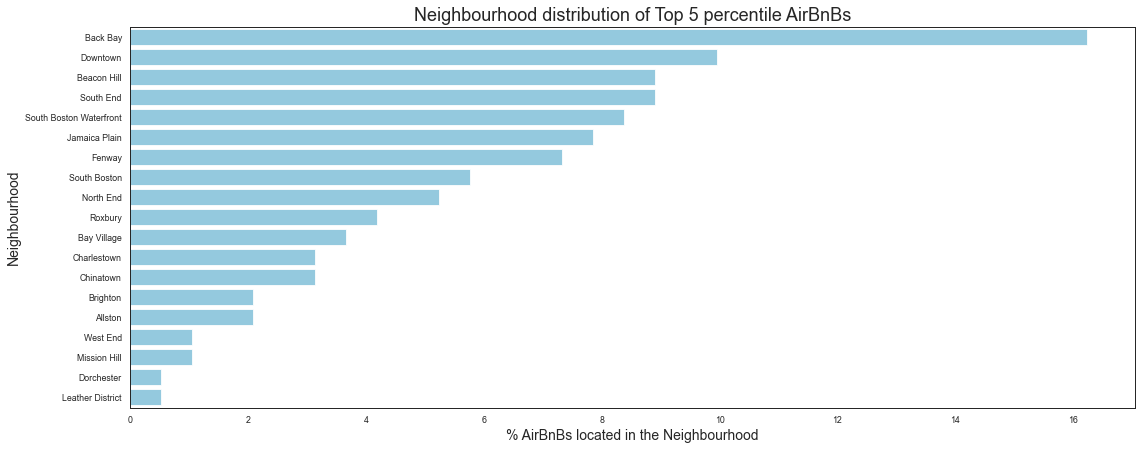

In [17]:
plot_bargraph(neighbourhood_dict_top_5_percentile, '% AirBnBs located in the Neighbourhood', 'Neighbourhood', 'Neighbourhood distribution of Top 5 percentile AirBnBs')

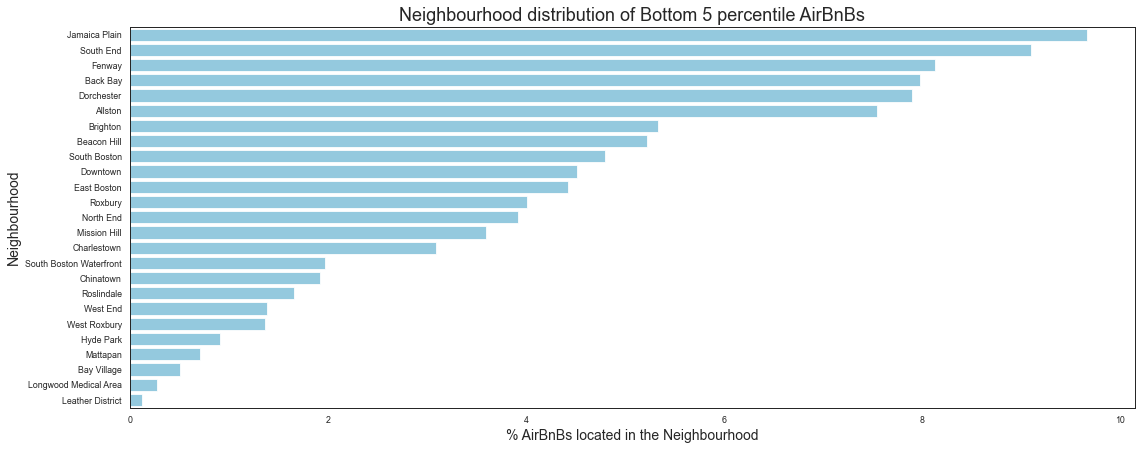

In [18]:
plot_bargraph(neighbourhood_dict_bottom_95_percentile, '% AirBnBs located in the Neighbourhood', 'Neighbourhood', 'Neighbourhood distribution of Bottom 5 percentile AirBnBs')

In [19]:
# you saw that huge difference of approximately 6 percentage points in graph titled 'Neighbourhood distribution of Top 5 percentile AirBnBs'?
# let's veriffy if that is the case. let's see if AirBnB's in 'Back Bay' neighbourhood are really expensive as compared to others
# for this let's see the distribution of prices

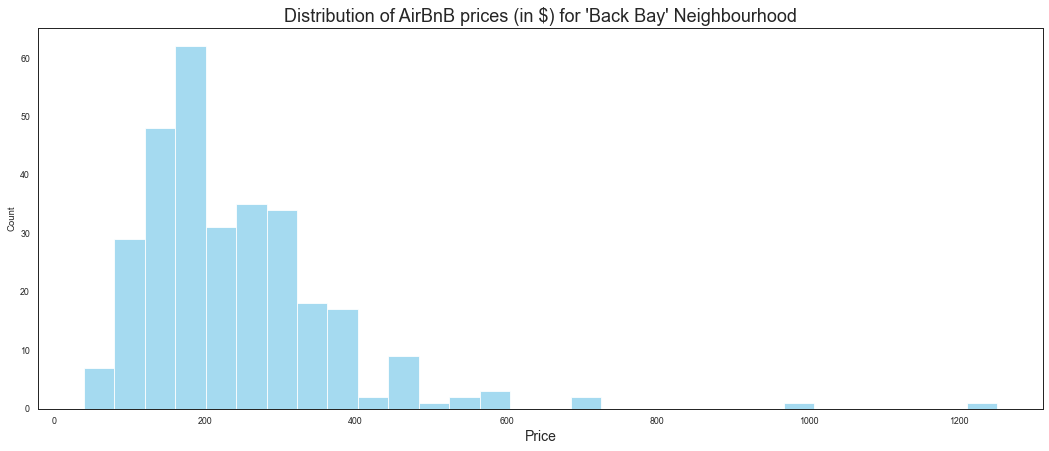

In [20]:
plot_histogram(listings_df[listings_df['neighbourhood_cleansed'] == 'Back Bay']['price'], 'Price', "Distribution of AirBnB prices (in $) for 'Back Bay' Neighbourhood")

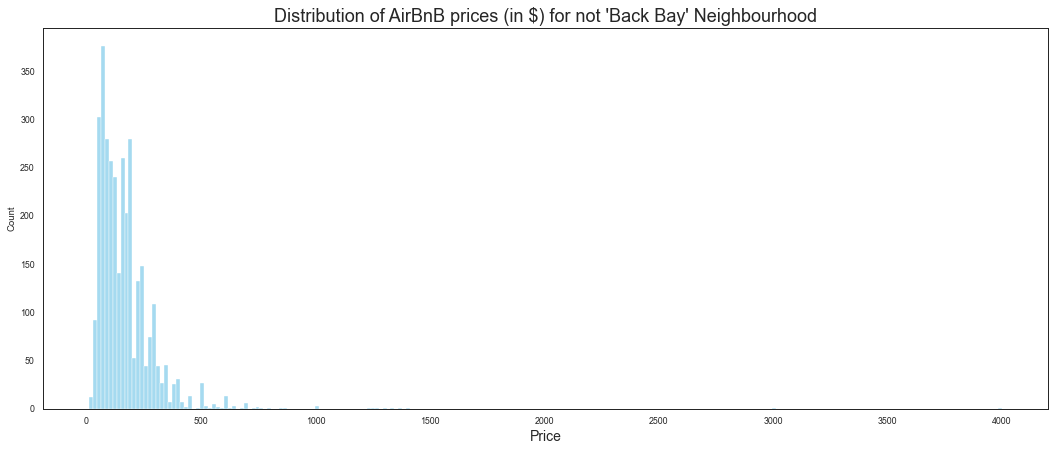

In [21]:
plot_histogram(listings_df[listings_df['neighbourhood_cleansed'] != 'Back Bay']['price'], 'Price', "Distribution of AirBnB prices (in $) for not 'Back Bay' Neighbourhood")

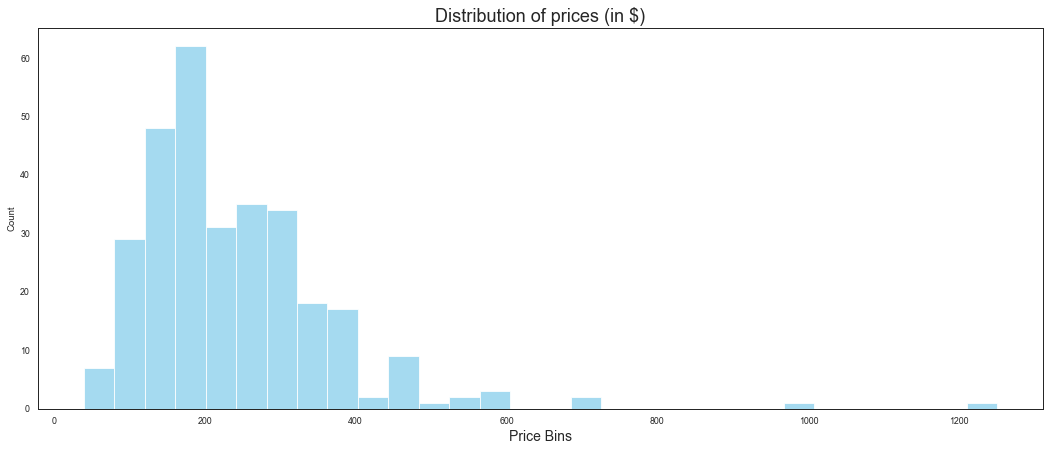

In [22]:
plot_histogram(listings_df[listings_df['neighbourhood_cleansed'] == 'Back Bay']['price'], 'Price Bins', "Distribution of prices (in $)")

In [23]:
listings_df[listings_df['neighbourhood_cleansed'] == 'Back Bay']['price'].describe()

count     302.000000
mean      240.950331
std       130.481478
min        40.000000
25%       160.000000
50%       209.000000
75%       299.000000
max      1250.000000
Name: price, dtype: float64

In [24]:
listings_df[listings_df['neighbourhood_cleansed'] != 'Back Bay']['price'].describe()

count    3283.000000
mean      167.760280
std       148.370898
min        10.000000
25%        80.000000
50%       140.000000
75%       209.000000
max      4000.000000
Name: price, dtype: float64

In [26]:
listings_df['price'].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [27]:
# from cells above we can conclude that 'Back Bay' tends to have higher property prices on average as compared to other neighbourhoods
# we can see there is 
#   a) almost 50% increase in average price of properties in 'Back Bay' neighbourhood
#   b) almost 43% increase in 75th quantile price of properties in 'Back Bay' neighbourhood

In [28]:
# question 1: what are the factors that justifies high price of AirBnBs. what factors makes them PREMIUM!
# answer 1:
#   we do not have many exmaples in our dataset to support this result but using general logic, we can say that larger square footage does costs more
#   and same goes for amenities as well. the more you offer to your guests, the more they will be willing to pay for, and this time we do have a lot of examples in support
#   okay the next point goes in-sync with our amenities question - we saw that kid/family friendly envionment in AirBnBs in top price band, relative to that
#   we here see accommodating more guests gives us more bucks. which is again fair going by general conscience
#   one last thing, looking into price trends in neighbourhoods of Boston, buy that property in Back Bay, the highend shops and all the fashion boutiques will benifit you

In [29]:
# so after looking into what amenities you should offer in you AirBnB and also on some of the factors that make guests pull out more money from their pockets,
# let's take a deep dive into what is the difference between amenities offered

# Question 2

In [30]:
def get_top_amenities_dict(amenity_series):
    '''
    input: pandas series
    output: python dictionary
    functionality: the function fetches top 10 eminities offered by the AirBnBs and stores in a python dictionary
    '''

    amenity_dict = {}
    for amenity_list in amenity_series:
        for amenity in amenity_list:
            if amenity in amenity_dict.keys():
                amenity_dict[amenity] += 1
            else:
                amenity_dict[amenity] = 1
    
    # fetching top 10 key-value pairs by value 
    amenity_dict = dict(Counter(amenity_dict).most_common(10))
    return(amenity_dict)

In [31]:
# what is difference in amenities offered by top and bottom 10 percentile (by Price) AirBnBs?

# let's start by fetching the 90th and 10th quantile price
price_90_percentile = listings_df['price'].quantile(q = 0.90)
price_10_percentile = listings_df['price'].quantile(q = 0.10)

print(f'We have 10% of listings with price >= {price_90_percentile} (top 10 percentile) and 10% of listing with price <= {price_10_percentile} (bottom 10 percentile)')

# subsetting the dataframes into top and bottom 10 percentile
top_10_percentile_dataframe = listings_df[listings_df['price'] >= price_90_percentile].reset_index(drop = True)
bottom_10_percentile_dataframe = listings_df[listings_df['price'] <= price_10_percentile].reset_index(drop = True)

top_10_percentile_amenity_dict = get_top_amenities_dict(top_10_percentile_dataframe['amenities'])
bottom_10_percentile_amenity_dict = get_top_amenities_dict(bottom_10_percentile_dataframe['amenities'])

We have 10% of listings with price >= 300.0 (top 10 percentile) and 10% of listing with price <= 60.0 (bottom 10 percentile)


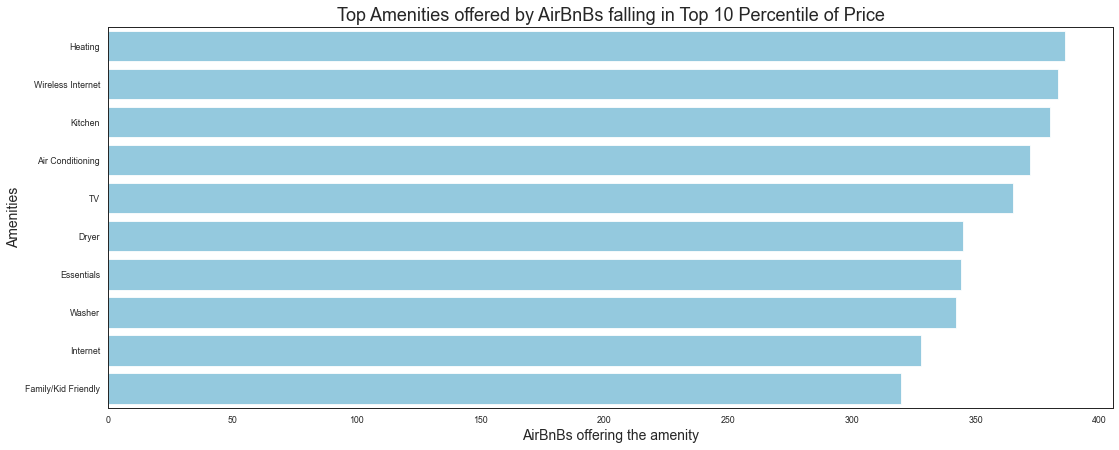

In [32]:
plot_bargraph(top_10_percentile_amenity_dict, 'AirBnBs offering the amenity', 'Amenities', 'Top Amenities offered by AirBnBs falling in Top 10 Percentile of Price')

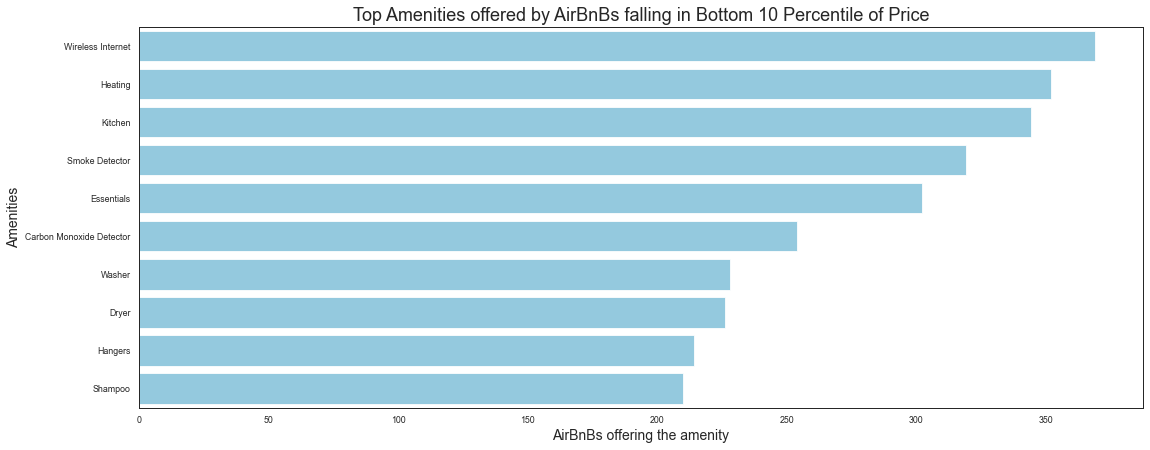

In [33]:
plot_bargraph(bottom_10_percentile_amenity_dict, 'AirBnBs offering the amenity', 'Amenities', 'Top Amenities offered by AirBnBs falling in Bottom 10 Percentile of Price')

In [34]:
# that plot did reflect the difference between amenities offered by most expensive AirBnBs and least expensive AirBnBs

In [35]:
# question 2: difference in amenities offered by top and bottom 10 percentile (by Price) AirBnBs?
# answer 2:
#   main emenities offered by AirBnBs in top price band are - ac, tv, internet, and kid/family freindly environment
#   though carbon monoxide detector is nice to have to have an alert on harmful air components around us, it is suprising it does not make it to the list from top band
#   AirBnBs but from the lower band. anyway, it is what it is

# Question 3

In [36]:
# let's look at time series plot of availability trends of all AirBnBs on day level
grouped_calendar_df = calendar_df.groupby(by = ['date', 'available']).agg({'listing_id': 'count', 'price': 'mean'}).reset_index().rename(columns = {'listing_id': 'count_of_properties'})

grouped_calendar_df_f = grouped_calendar_df[grouped_calendar_df['available'] == 'f'][['date', 'count_of_properties']]
grouped_calendar_df_t = grouped_calendar_df[grouped_calendar_df['available'] == 't'][['date', 'count_of_properties', 'price']]

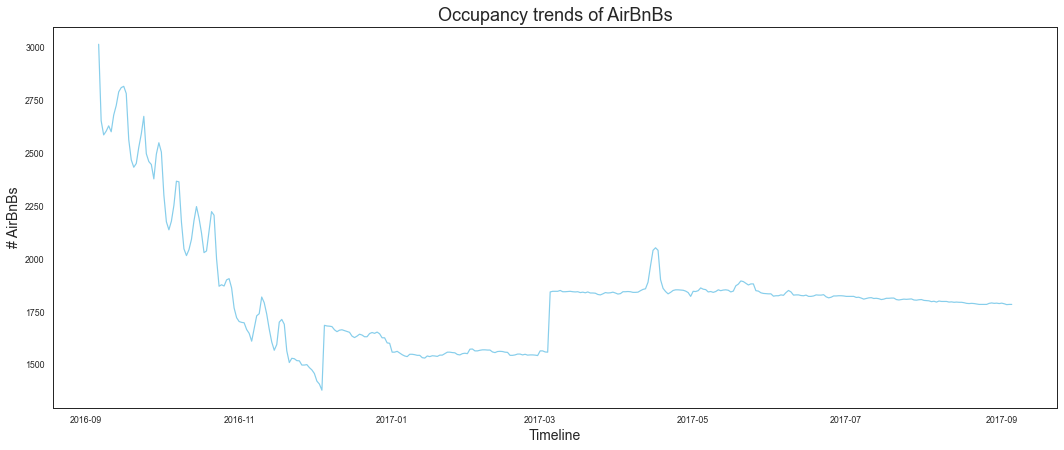

In [37]:
plot_lineplot(grouped_calendar_df_f, 'date', 'count_of_properties', 'Timeline', '# AirBnBs', 'Occupancy trends of AirBnBs')

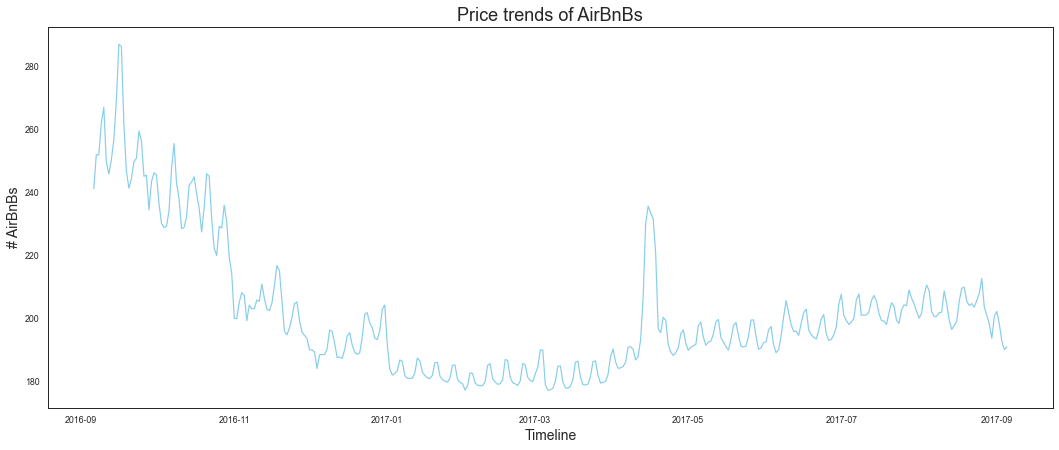

In [38]:
plot_lineplot(grouped_calendar_df_t, 'date', 'price', 'Timeline', '# AirBnBs', 'Price trends of AirBnBs')

In [39]:
# so the two line plots validates the supply-demand curve but does not provide any important insight on availability-occupancy-price trends except for in 2016
# but this range of time -09/2016 to 12/2016- too have lot of fluctuations
# let's see if we can find a trend for particular neighbouthood
# to accomplish this will need to merge the 'listing_df' and 'calendar_df' and see for any mismatching listings between the two

if set(calendar_df['listing_id'].unique().tolist()) == set(listings_df['id'].unique().tolist()):
    print('No mismatch between listings from to dataframes')
else:
    print('Oops, we need further analysis as their is/are mismatch between listings from two dataframes')

No mismatch between listings from to dataframes


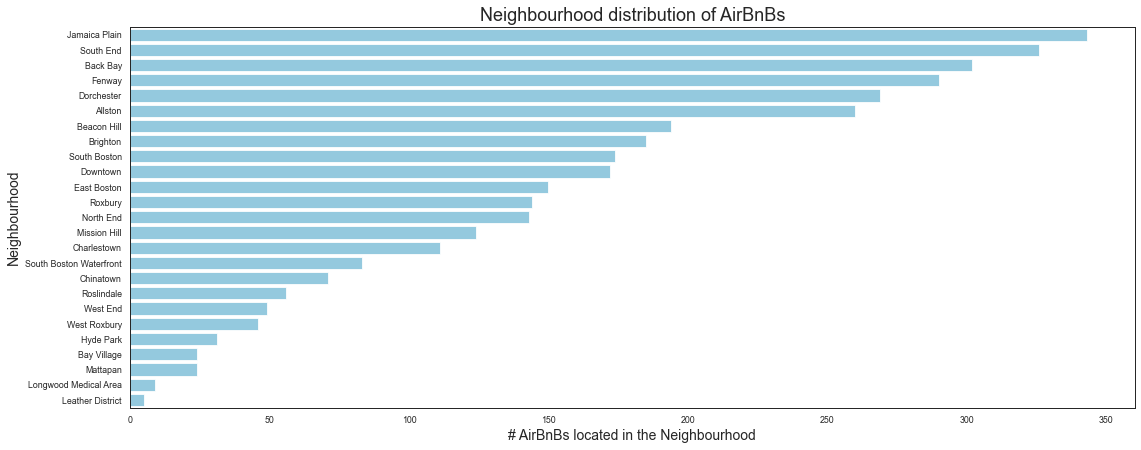

In [40]:
# that is nice, let's start by merging the two dataframes
merged_df = pd.merge(left = calendar_df, right = listings_df[['id', 'neighbourhood_cleansed']], left_on = 'listing_id', right_on = 'id')

# let's plot the distribution of properties by neighbourhood
total_property_count_df = merged_df.groupby(['neighbourhood_cleansed', 'id']).agg({'listing_id': 'count'}).reset_index().groupby('neighbourhood_cleansed').agg({'id': 'count'}).reset_index().rename(columns = {'id': 'total_properties'})
neighbourhood_dist_dict  = dict(zip(total_property_count_df['neighbourhood_cleansed'], total_property_count_df['total_properties']))
neighbourhood_dist_dict = {k: v for k, v in sorted(neighbourhood_dist_dict.items(), key = lambda item : item[1], reverse = True)}

plot_bargraph(neighbourhood_dist_dict, '# AirBnBs located in the Neighbourhood', 'Neighbourhood', 'Neighbourhood distribution of AirBnBs')

In [41]:
merged_df = merged_df.groupby(by = ['year_month', 'neighbourhood_cleansed', 'available']).agg({'id': 'count', 'price': 'mean'}).reset_index().rename(columns = {'id': 'count_of_properties'})

In [42]:
merged_df_t = merged_df[merged_df['available'] == 't'][['year_month', 'neighbourhood_cleansed', 'count_of_properties', 'price']]
merged_df_f = merged_df[merged_df['available'] == 'f'][['year_month', 'neighbourhood_cleansed', 'count_of_properties']]

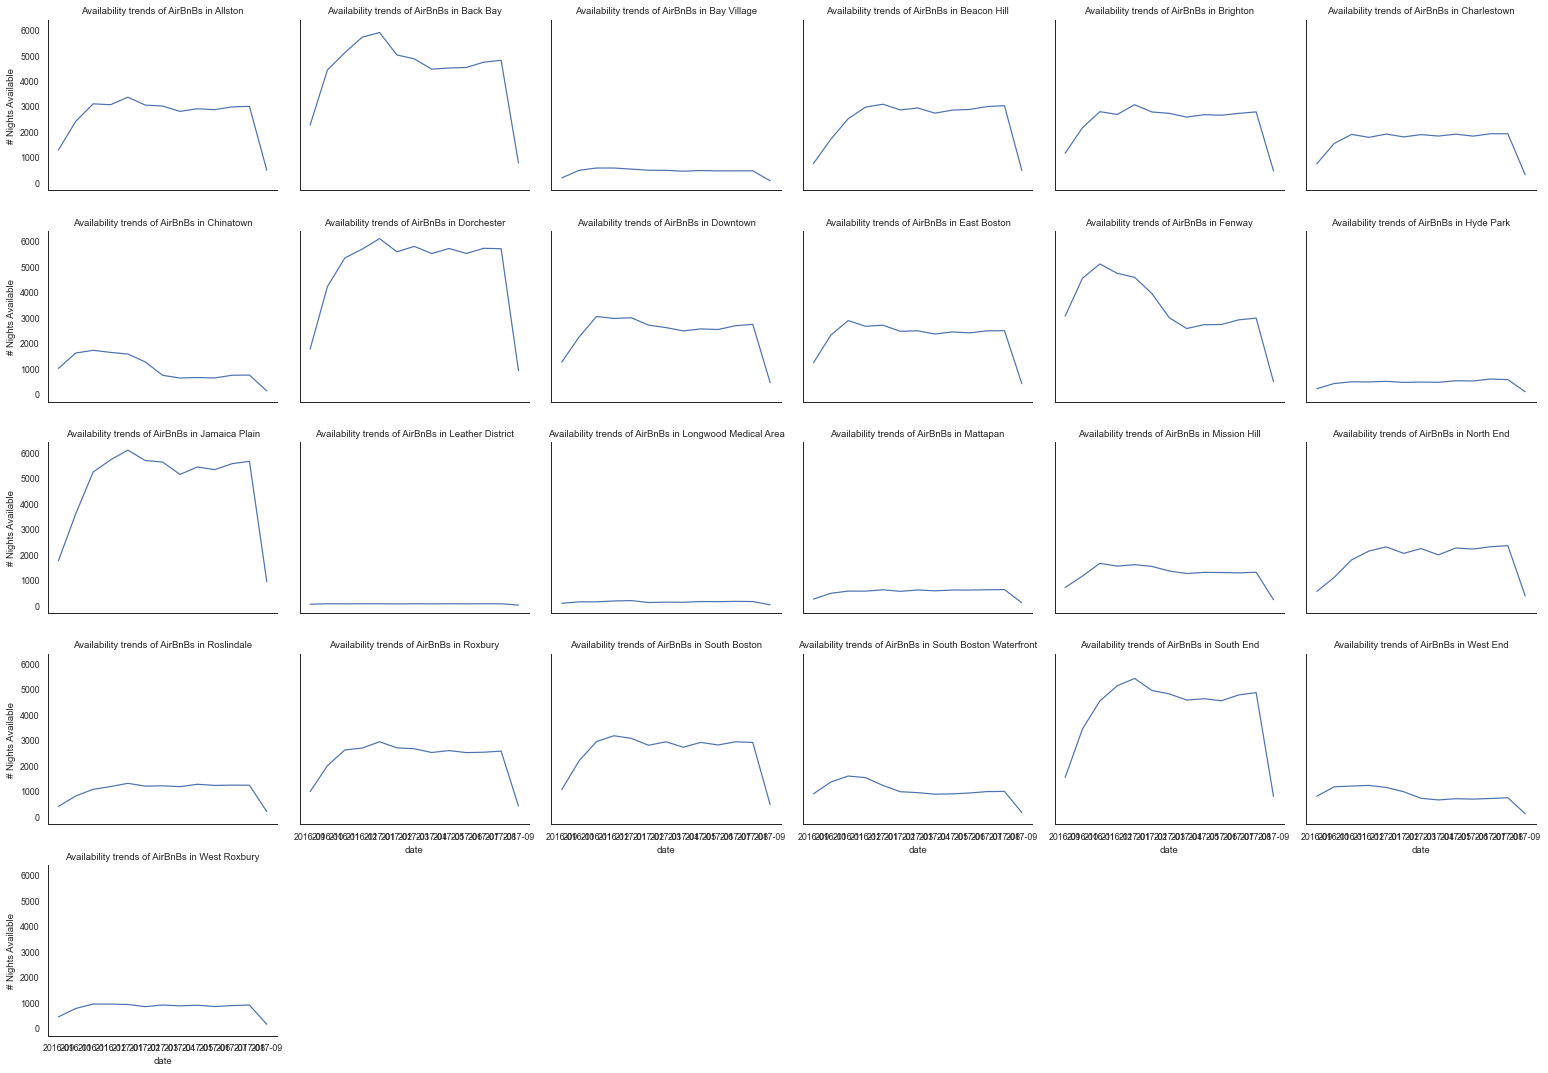

In [43]:
sns.set_context('paper')
sns.set_style('white')
sns_fg = sns.FacetGrid(data = merged_df_t, col = 'neighbourhood_cleansed', height = 3, aspect = 1.2, margin_titles = True, col_wrap = 6)
sns_fg.map_dataframe(sns.lineplot, x = 'year_month', y = 'count_of_properties')
sns_fg.set_axis_labels('date', '# Nights Available')
sns_fg.set_titles(col_template = 'Availability trends of AirBnBs in {col_name}');

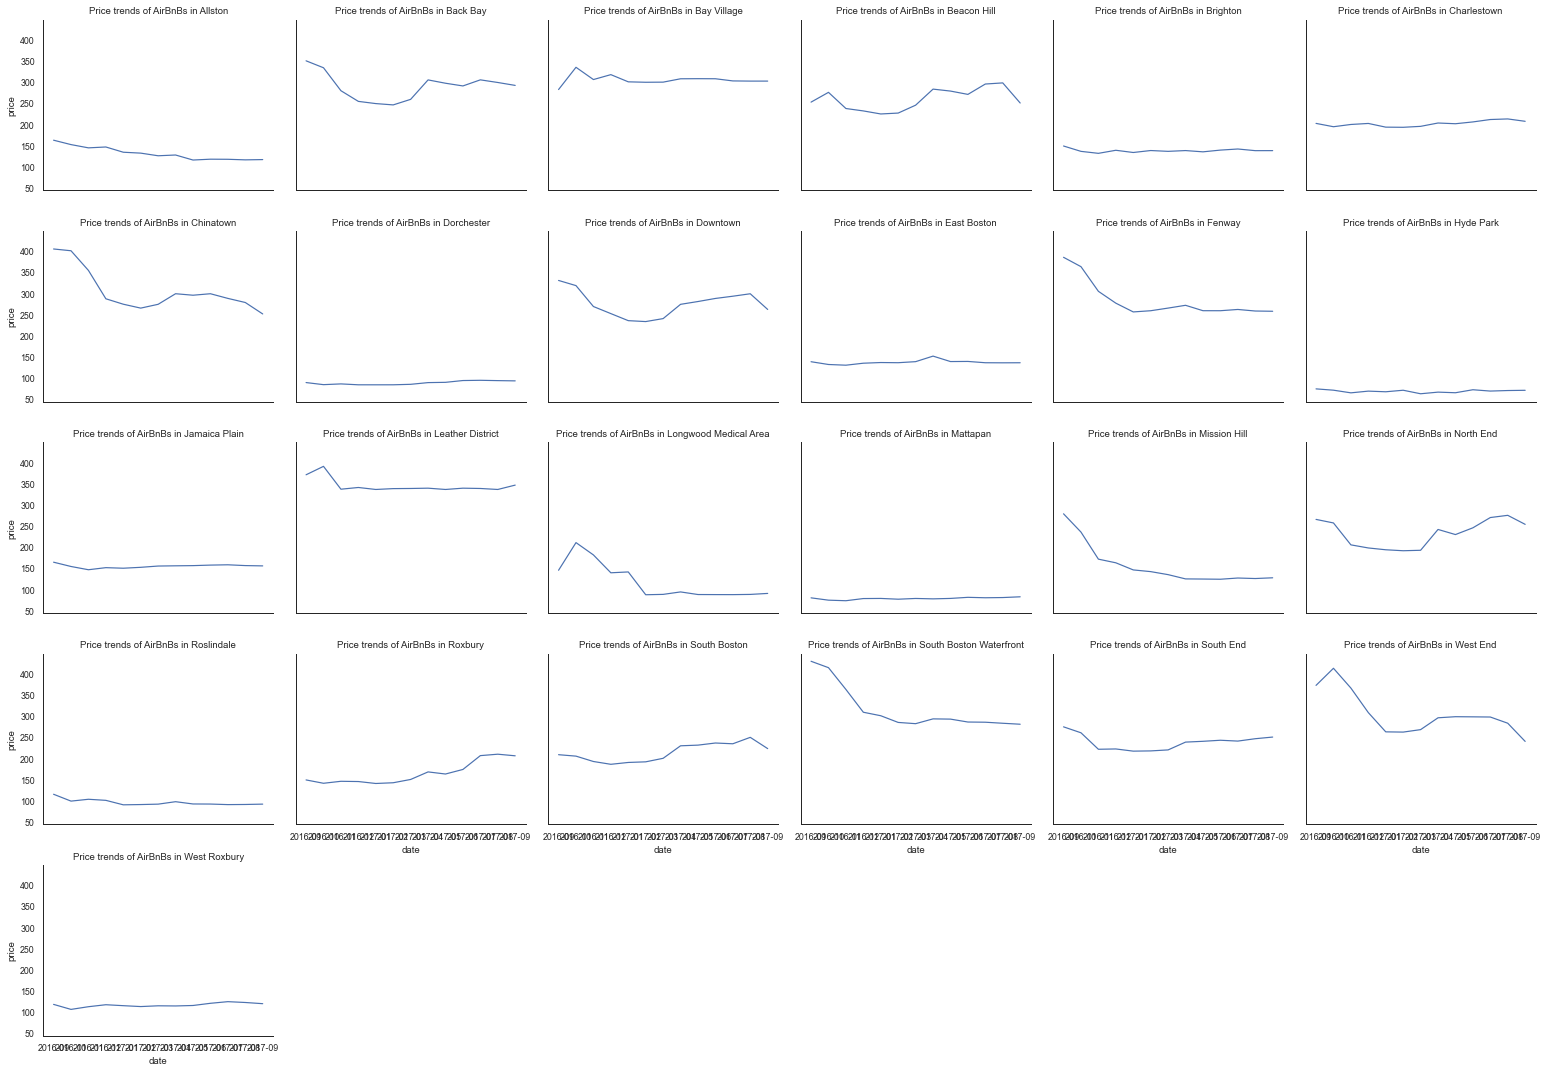

In [44]:
# okay, nothing much from here except we see a little decrease in availability in 'Back Bay' and 'Fenway' neighbourhood in between months of Jan-Feb 2017
# let's see if we have the same correlation between prices as well
sns.set_context('paper')
sns.set_style('white')
sns_fg = sns.FacetGrid(data = merged_df_t, col = 'neighbourhood_cleansed', height = 3, aspect = 1.2, margin_titles = True, col_wrap = 6)
sns_fg.map_dataframe(sns.lineplot, x = 'year_month', y = 'price')
sns_fg.set_axis_labels('date', 'price')
sns_fg.set_titles(col_template = 'Price trends of AirBnBs in {col_name}');

In [45]:
# okay, so from here we see there is a little increase in prices of AirBnBs in Jan-Feb 2017 for 'Back Bay' neighbourhood but not for 'Fenway' neighbourhood
# we can dive one level of granulairity and see if we can find any trend in daily level data
# let's start over

In [46]:
merged_df = pd.merge(left = calendar_df, right = listings_df[['id', 'neighbourhood_cleansed']], left_on = 'listing_id', right_on = 'id')
merged_df = merged_df.groupby(by = ['date', 'neighbourhood_cleansed', 'available']).agg({'id': 'count', 'price': 'mean'}).reset_index().rename(columns = {'id': 'count_of_properties'})
merged_df_t = merged_df[merged_df['available'] == 't'][['date', 'neighbourhood_cleansed', 'count_of_properties', 'price']]
merged_df_f = merged_df[merged_df['available'] == 'f'][['date', 'neighbourhood_cleansed', 'count_of_properties']]

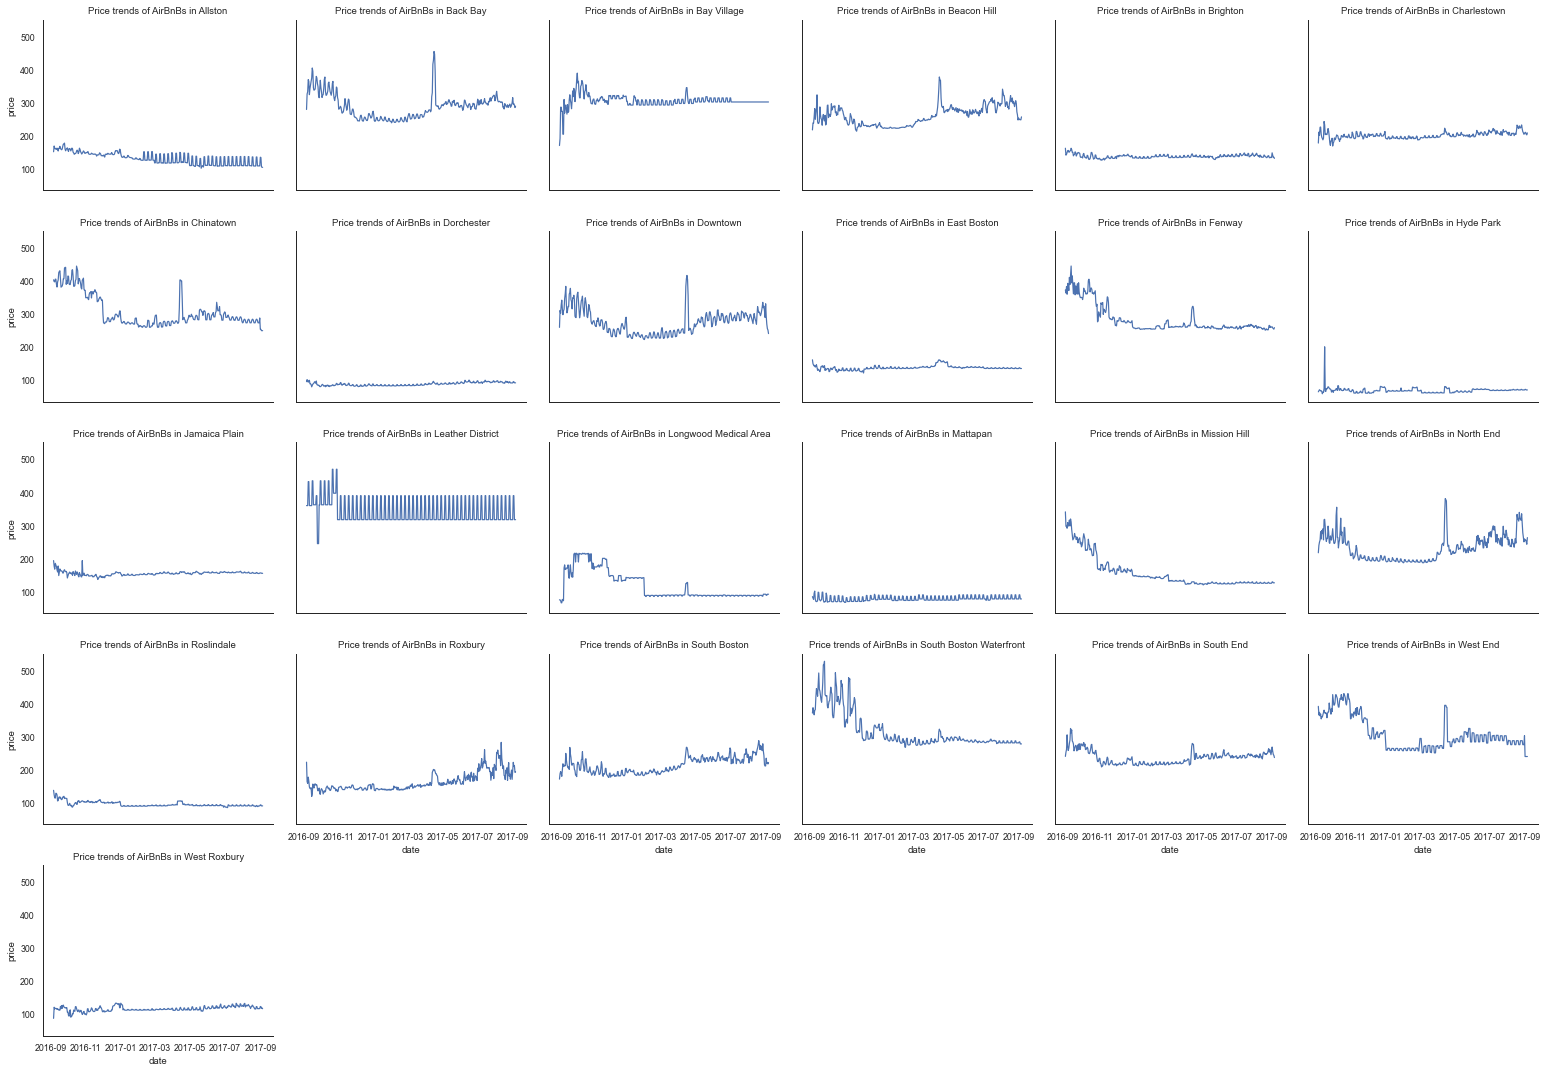

In [47]:
sns.set_context('paper')
sns.set_style('white')
sns_fg = sns.FacetGrid(data = merged_df_t, col = 'neighbourhood_cleansed', height = 3, aspect = 1.2, margin_titles = True, col_wrap = 6)
sns_fg.map_dataframe(sns.lineplot, x = 'date', y = 'price')
sns_fg.set_axis_labels('date', 'price')
sns_fg.set_titles(col_template = 'Price trends of AirBnBs in {col_name}');

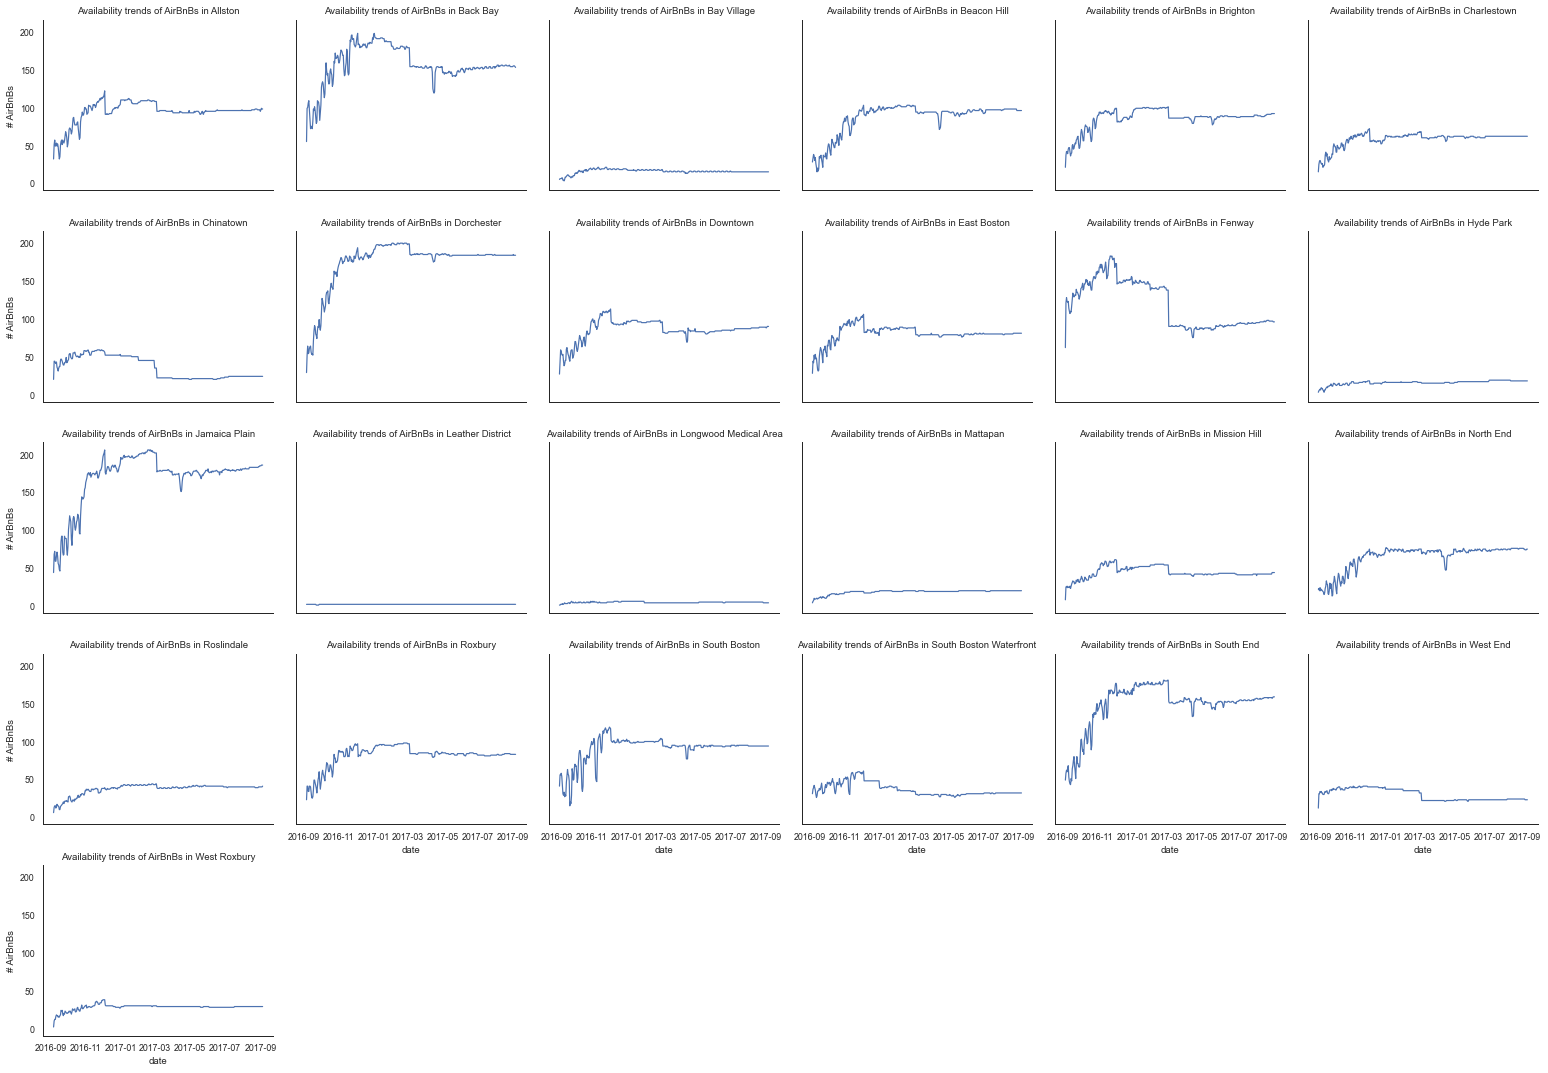

In [48]:
sns.set_context('paper')
sns.set_style('white')
sns_fg = sns.FacetGrid(data = merged_df_t, col = 'neighbourhood_cleansed', height = 3, aspect = 1.2, margin_titles = True, col_wrap = 6)
sns_fg.map_dataframe(sns.lineplot, x = 'date', y = 'count_of_properties')
sns_fg.set_axis_labels('date', '# AirBnBs')
sns_fg.set_titles(col_template = 'Availability trends of AirBnBs in {col_name}');

In [49]:
# i think it is safe conclude from here that most of the the trafic that AirBnBs sees is near the fall
# but we do see a sudden dip in availability (and hence a sudden spike in prices) in april 2017, not sure why that happened

# question 3: what is the best time to properties up as AirBnBs
# answer 3:
#   we saw that most of the the trafic that AirBnBs experience is near the fall except for say an exception in april 2017